# Descriptive analysis of Dataset 1 and processing
This notebooks loads the dataset 1 and analyzes its overlap with each of the databases and PathMe.
Finally, it exports to the format ready to be used by DiffuPy/DiffuPath

In [1]:
import os
import itertools
import time

In [2]:
from openpyxl import load_workbook
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl # 3.1.1

In [32]:
import pybel
from pybel import BELGraph
from pybel.constants import RELATION, ANNOTATIONS, MIRNA, ABUNDANCE
from pybel.struct import get_subgraph_by_annotation_value, remove_filtered_nodes
from pybel import function_inclusion_filter_builder
from pybel.dsl import Abundance, BiologicalProcess, CentralDogma, ListAbundance, Reaction
from pybel.struct.summary import count_functions

from pybel_tools.summary import plot_summary

pybel.get_version()

'0.13.2'

In [4]:
mpl.rcParams['figure.dpi'] = 200

In [5]:
from pathme.constants import REACTOME_BEL, KEGG_BEL, WIKIPATHWAYS_BEL, PATHME_DIR
from pathme.export_utils import to_gml

In [6]:
import diffupy

In [28]:
from diffupy.diffuse import diffuse
from diffupy.kernels import regularised_laplacian_kernel
from diffupy.matrix import Matrix, LaplacianMatrix
from diffupy.process_input import generate_categoric_input_from_labels
from diffupy.utils import print_dict_dimensions, get_label_list_graph

from diffupath.validation_datasets_parsers import parse_set1
from diffupath.input_mapping import get_mapping, get_mapping_subsets, get_mapping_two_dim_subsets
from diffupath.pathme_processing import get_set_database, calculate_database_sets_as_dict
from diffupath.utils import get_labels_set_from_dict, reduce_dict_dimension
from diffupath.views import show_heatmap

## Load dataset 1

In [8]:
HERE = os.path.dirname(os.path.realpath('__file__'))
ROOT_DIR = os.path.join(os.path.abspath(os.path.join(HERE, os.pardir)))
ROOT_DIR = os.path.join(os.path.abspath(os.path.join(ROOT_DIR, os.pardir)))
ROOT_DIR = os.path.join(os.path.abspath(os.path.join(ROOT_DIR, os.pardir)))
ROOT_DIR = os.path.join(os.path.abspath(os.path.join(ROOT_DIR, os.pardir)))

dataset1_labels_by_omics = parse_set1(os.path.join(ROOT_DIR, 'data', 'validation_datasets', 'set1.xlsx'))

In [9]:
print_dict_dimensions(dataset1_labels_by_omics, 'Dataset1 imported labels:')

Dataset1 imported labels:
Total number of genes: 4941  
Total number of micrornas: 100  
Total number of metabolite: 21  
Total: 5062 


In [10]:
dataset1_all_labels = get_labels_set_from_dict(dataset1_labels_by_omics)

## 2. Load PathMe Universe

### 2.1. PathMeUniverse import

In [11]:
pathme_universe_graph_no_flatten = pybel.from_pickle(
    os.path.join(ROOT_DIR, 'data', 'pickles', 'universe', 'pathme_universe_non_flatten_collapsed_names_no_isolates_16_03_2020.pickle')
)


In [12]:
pathme_universe_graph_no_flatten.summarize()

PathMe Universe v1.0.0
Number of Nodes: 42272
Number of Edges: 105871
Number of Citations: 7695
Number of Authors: 0
Network Density: 5.92E-05
Number of Components: 435
Number of Warnings: 0


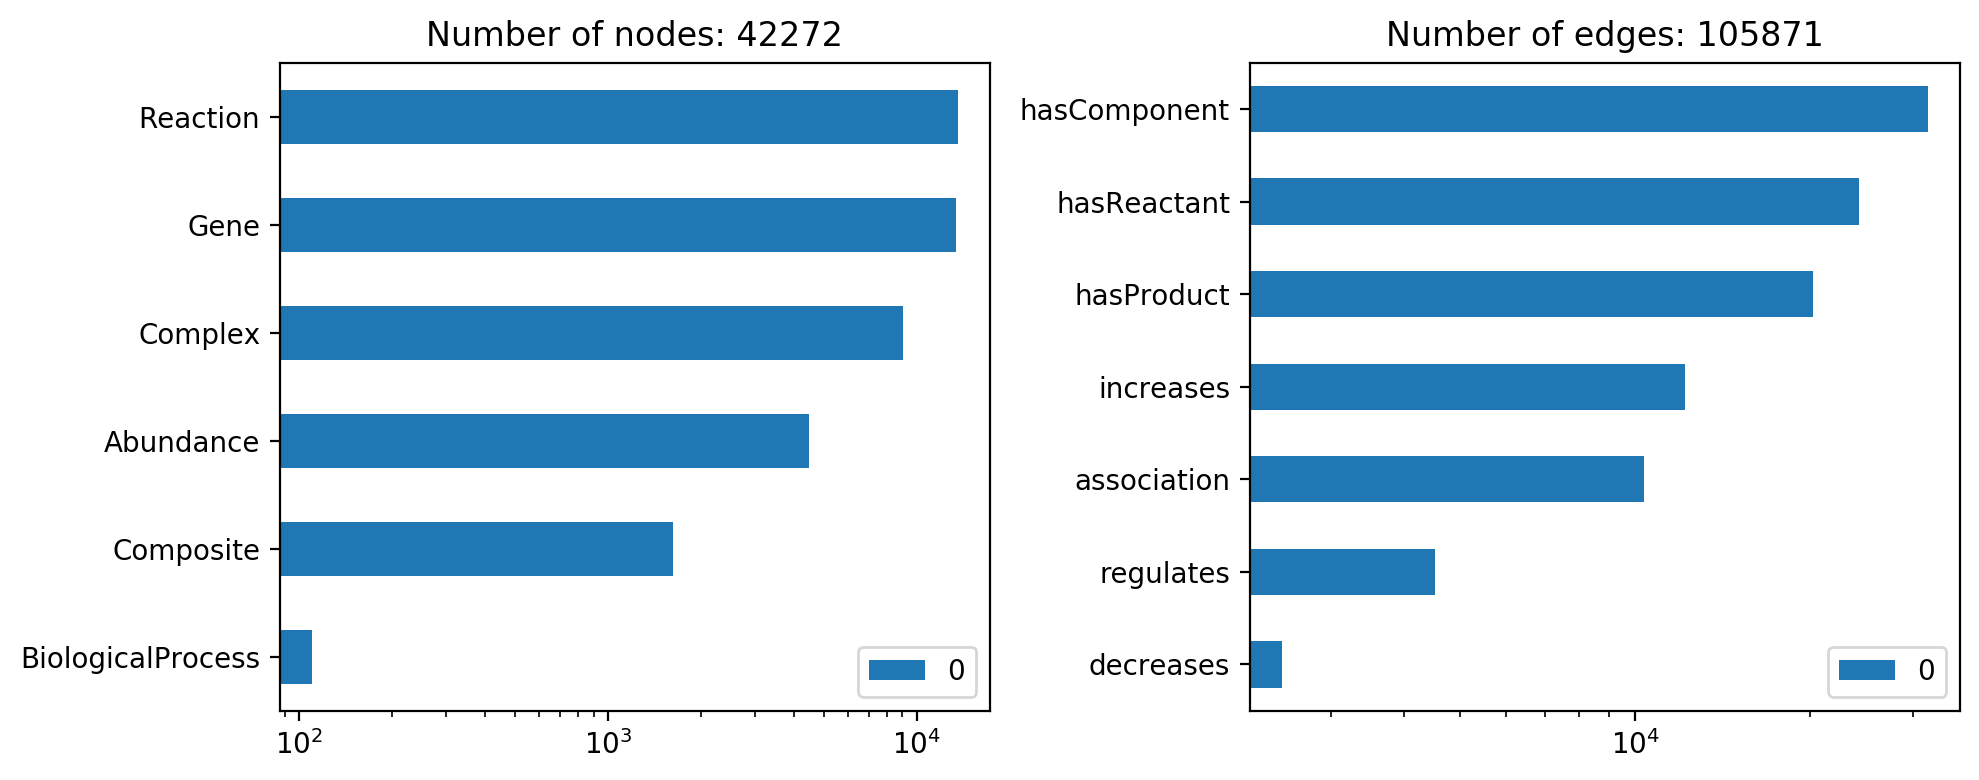

In [13]:
plot_summary(pathme_universe_graph_no_flatten, plt, figsize=(10, 4))
plt.show()

##### Processing

In [ ]:
remove_filtered_nodes(pathme_universe_graph_no_flatten, node_predicates=function_inclusion_filter_builder(MIRNA))
remove_filtered_nodes(pathme_universe_graph_no_flatten, node_predicates=function_inclusion_filter_builder(ABUNDANCE))
pathme_universe_graph_no_flatten.summarize()

PathMe Universe v1.0.0
Number of Nodes: 37799
Number of Edges: 77295
Number of Citations: 6763
Number of Authors: 0
Network Density: 5.41E-05
Number of Components: 2995
Number of Warnings: 0


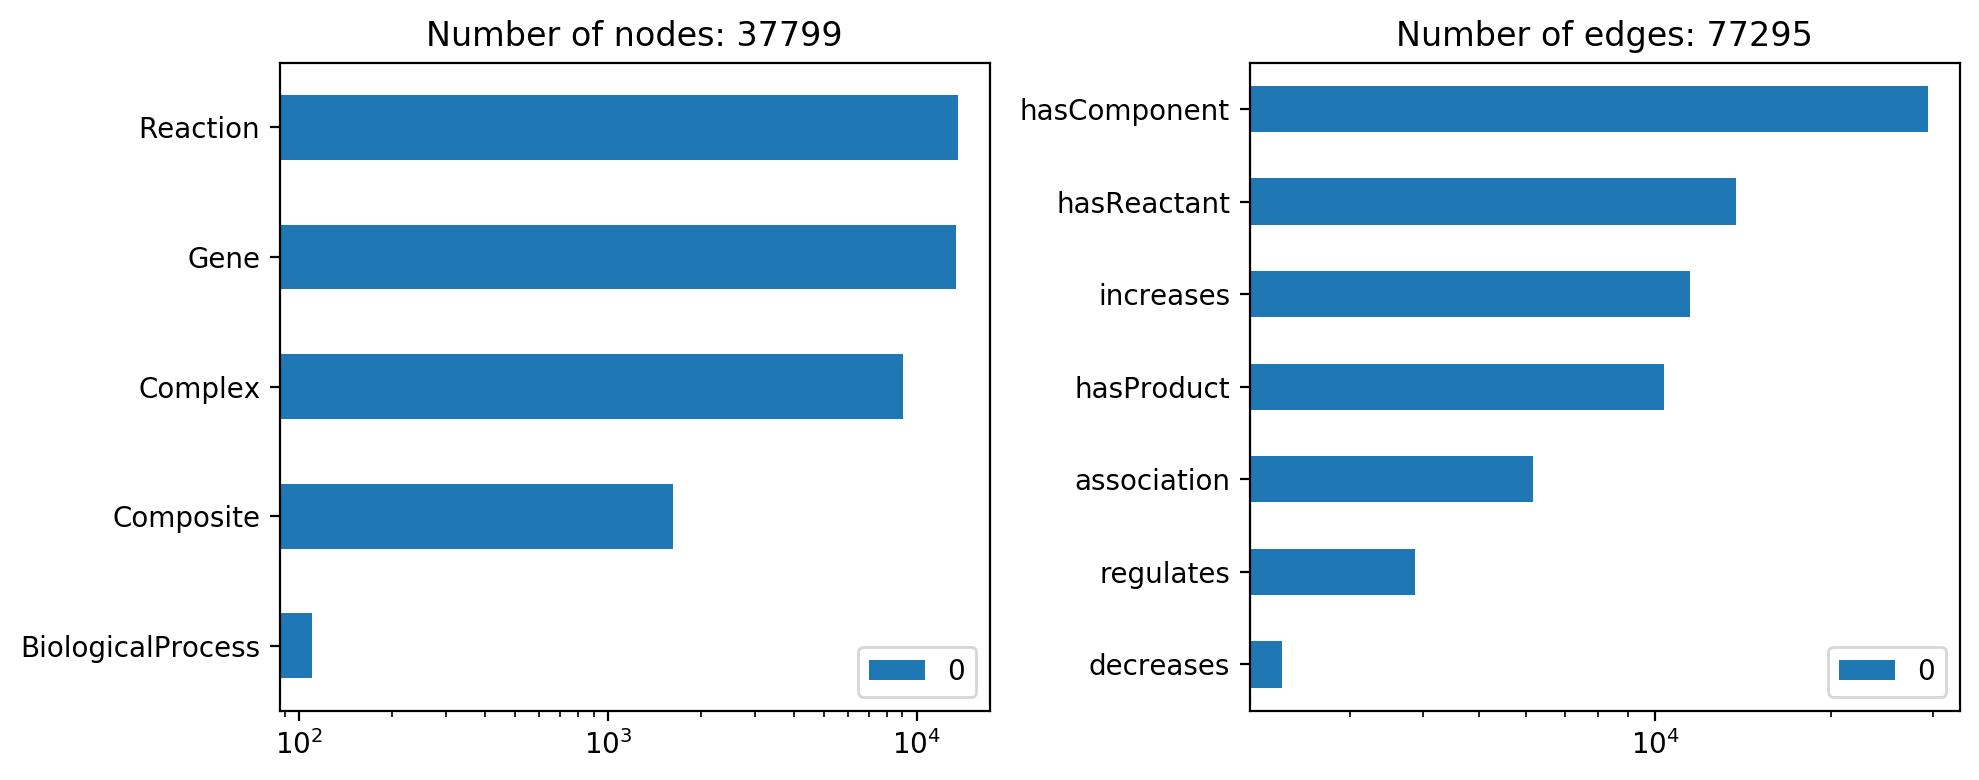

In [15]:
pathme_universe_graph_no_flatten.summarize()
count_functions(pathme_universe_graph_no_flatten)
plot_summary(pathme_universe_graph_no_flatten, plt, figsize=(10, 4))
plt.show()

### 2.2. Get labels subsets by entity type (omic) and database

##### PathMe package subsets

In [20]:
def get_labels_by_db_and_omic_from_pathme(databases):
    db_entites = defaultdict(dict)
    entites_db = defaultdict(lambda: defaultdict(set))
    
    for db in databases:
        genes, mirna, metabolites, bps = get_set_database(db)
        db_entites[db] = {'genes': genes, 'mirna': mirna, 'metabolites': metabolites, 'bps': bps}
        
        for entity_type, entities in db_entites[db].items():
            entites_db[entity_type][db] = entities
            
    return db_entites, entites_db

In [23]:
bg_labels_from_pathme_by_db_and_omic, bg_labels_from_pathme_by_omic_and_db = get_labels_by_db_and_omic_from_pathme(['reactome', 'kegg', 'wikipathways'])

print_dict_dimensions(bg_labels_from_pathme_by_db_and_omic, 'Entities in PathMe package :')

Entities in PathMe package :
Total number of reactome: genes(0), mirna(0), metabolites(0), bps(0),  
Total number of kegg: genes(7803), mirna(149), metabolites(4452), bps(461),  
Total number of wikipathways: genes(0), mirna(0), metabolites(0), bps(0),  
Total: 12865 


In [25]:
bg_labels_from_pathme_by_omic = reduce_dict_dimension(bg_labels_from_pathme_by_omic_and_db)
mirnas = bg_labels_from_pathme_by_omic['mirna']

#####  PathMeUniverse Graph Subsets

In [29]:
def get_labels_by_db_and_omic_from_graph(graph):
    
    db_subsets = defaultdict(set)
    db_entites = defaultdict(dict)
    entites_db = defaultdict(dict)

    #entity_type_map = {'Gene':'genes', 'mirna_nodes':'mirna', 'Abundance':'metabolites', 'BiologicalProcess':'bps'}

    for u, v, k in graph.edges(keys=True):
        
        if ANNOTATIONS not in graph[u][v][k]:
            continue
            
        if 'database' not in graph[u][v][k][ANNOTATIONS]:
            continue
            
        for database in graph[u][v][k][ANNOTATIONS]['database']:
            db_subsets[database].add(u)
            db_subsets[database].add(v)
        
    for database, nodes in db_subsets.items():
        db_entites[database] = calculate_database_sets_as_dict(nodes, database)
        
        database_sets = calculate_database_sets_as_dict(nodes, database)
        
        db_entites[database] = database_sets
    
        for entity_type, entities in database_sets.items():
            entites_db[entity_type][database] = entities
        
    return db_entites, entites_db

In [30]:
bg_labels_from_pathmeuniverse_by_db_and_omic, bg_labels_from_pathmeuniverse_by_omic_and_db =  get_labels_by_db_and_omic_from_graph(pathme_universe_graph_no_flatten)

print_dict_dimensions(bg_labels_from_pathmeuniverse_by_db_and_omic, 'Entities in PathMeUniverse :')

Entities in PathMeUniverse :
Total number of wikipathways: gene_nodes(2452), mirna_nodes(91), metabolite_nodes(0), bp_nodes(0),  
Total number of kegg: gene_nodes(6023), mirna_nodes(122), metabolite_nodes(0), bp_nodes(107),  
Total number of reactome: gene_nodes(8584), mirna_nodes(13), metabolite_nodes(0), bp_nodes(3),  
Total: 17395 


## 3. Dataset label mapping to PathMeEntities

### General mapping

In [31]:
all_labels_mapping = get_mapping(dataset1_all_labels, background_labels, title = 'Global mapping: ', mirnas=mirnas, print_percentage = True)

NameError: name 'background_labels' is not defined

### Mapping by subsets

#### Mapping by entity type/omic

In [ ]:
mapping_by_entity, _, _ = get_mapping_subsets(
    dataset1_labels_by_omics,
    background_labels,
    'entity type/omic',
    mirnas=mirnas,
)

In [ ]:
micrornas_mapping = mapping_by_entity['micrornas'][0]
micrornas_mapping

#### Mapping by database

In [ ]:
background_entites_by_db = {db : set(itertools.chain.from_iterable(entities.values())) for db, entities in bg_labels_from_pathmeuniverse_by_db_and_omic.items()}
mapping_by_db, _, _ = get_mapping_subsets(background_entites_by_db, dataset1_all_labels, 'database', mirnas=mirnas, submapping = background_labels, mirnas_mapping = micrornas_mapping, percentage_reference_labels = True)


#### Mapping by entity type and database

In [ ]:
mapping_by_database_and_entity, total_percentage, total_dimention = get_mapping_two_dim_subsets(bg_labels_from_pathmeuniverse_by_db_and_omic, dataset1_all_labels, relative_statistics = dataset1_labels_by_omics, mirnas_mapping = micrornas_mapping)


### Mapping descriptive view

In [ ]:
all_count = []
all_percentage = []

entity_type_map = {'metabolite_nodes': 'metabolite', 'mirna_nodes': 'micrornas', 'gene_nodes': 'genes',
                    'bp_nodes': 'bps'}

for db_name, entities_by_type in mapping_by_database_and_entity.items():
    db_count = []
    db_percentage = []

    for entity_type, entities_tupple in entities_by_type[0].items():
        db_count.append(len(entities_tupple[0]))
        db_percentage.append(entities_tupple[1])
        
        
    all_count.append(db_count)
    all_percentage.append(db_percentage)

db_count = []
db_percentage = []
for entity, entities_tupple in mapping_by_entity.items():
    db_count.append(len(entities_tupple[0]))
    db_percentage.append(entities_tupple[1])
    


In [ ]:
import numpy as np

databases = list(mapping_by_database_and_entity.keys())
databases.append('arreu')


entity_types = mapping_by_database_and_entity['kegg'][0].keys()

entity_number = np.array(all_percentage)
entity_count = np.array(all_count)

In [ ]:
databases = mapping_by_database_and_entity.keys()
entity_types = mapping_by_database_and_entity['kegg'][0].keys()

entity_number = np.array(all_percentage)
entity_count = np.array(all_count)

In [ ]:
show_heatmap(entity_number, entity_count, databases, entity_types)

In [ ]:
kegg_reactome = mapping_by_db['kegg'][0].intersection(mapping_by_db['reactome'][0])
kegg_wikipathways = mapping_by_db['kegg'][0].intersection(mapping_by_db['wikipathways'][0])
core = kegg_wikipathways.intersection(kegg_reactome)

reactome_wikipathways = mapping_by_db['reactome'][0].intersection(mapping_by_db['wikipathways'][0]) - core

unique_kegg = mapping_by_db['kegg'][0] - kegg_reactome - kegg_wikipathways
unique_reactome = mapping_by_db['reactome'][0] - kegg_reactome - reactome_wikipathways
unique_wikipathways = mapping_by_db['wikipathways'][0] - kegg_wikipathways - reactome_wikipathways



In [ ]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
 
plt.figure(figsize=(17,8)) 
v=venn3(subsets = (len(unique_kegg), len(unique_reactome), len(kegg_reactome), len(unique_wikipathways), len(kegg_wikipathways), len(reactome_wikipathways), len(core)), set_labels = ('Keeg', 'Reactome', 'Wikipathways'))

plt.show()

## 5. Export ready to be used in DiffuPy/DiffuPath

FIXME